Import all the **Dependencies**

In [ ]:
import os
import cv2
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator

img_size = 224
target_count = 987  # Target number of images for no_appendicitis
no_appendicitis_path = 'path_to_no_appendicitis_folder'  # Replace with the actual path
augmented_no_appendicitis_path = 'path_to_augmented_no_appendicitis_folder'  # Replace with the actual path

# Ensure the directory exists
os.makedirs(augmented_no_appendicitis_path, exist_ok=True)

# Load and resize images
def load_and_resize_images(folder):
    images = []
    for filename in os.listdir(folder):
        img_path = os.path.join(folder, filename)
        img = cv2.imread(img_path)
        if img is not None:
            resized_img = cv2.resize(img, (img_size, img_size))
            images.append(resized_img)
    return images

# Augment images to reach target count
def augment_images(images, target_count, output_folder):
    datagen = ImageDataGenerator(
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest'
    )

    images = np.array(images)
    augmented_images = []

    while len(augmented_images) + len(images) < target_count:
        for img in images:
            img = img.reshape((1,) + img.shape)  # Reshape to (1, img_size, img_size, 3)
            aug_iter = datagen.flow(img, batch_size=1)
            aug_img = next(aug_iter)[0].astype(np.uint8)  # Get the augmented image and convert to uint8
            augmented_images.append(aug_img)
            if len(augmented_images) + len(images) >= target_count:
                break

    for i, img in enumerate(augmented_images):
        save_path = os.path.join(output_folder, f"aug_no_appendicitis_{i + len(images)}.jpg")
        cv2.imwrite(save_path, img)

    print(f"Augmented {len(augmented_images)} images to match the target count.")

# Main execution
no_appendicitis_images = load_and_resize_images(no_appendicitis_path)
augment_images(no_appendicitis_images, target_count, augmented_no_appendicitis_path)


In [1]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Set all the **Constants**

In [3]:
BATCH_SIZE = 32
IMAGE_SIZE = 256
CHANNELS=3
EPOCHS=50

Import data into tensorflow dataset **object**

In [4]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/drive/MyDrive/US_updated",
    seed=123,
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 1974 files belonging to 2 classes.


In [5]:
class_names = dataset.class_names
class_names

['appendicitis', 'no_appendicitis']

In [6]:
for image_batch, labels_batch in dataset.take(1):
    print(image_batch.shape)
    print(labels_batch.numpy())

(32, 256, 256, 3)
[1 1 0 1 0 1 1 1 0 1 0 0 1 1 1 0 0 1 0 0 0 0 1 0 0 0 1 0 1 1 1 1]



Visualize some of the images from our **dataset**

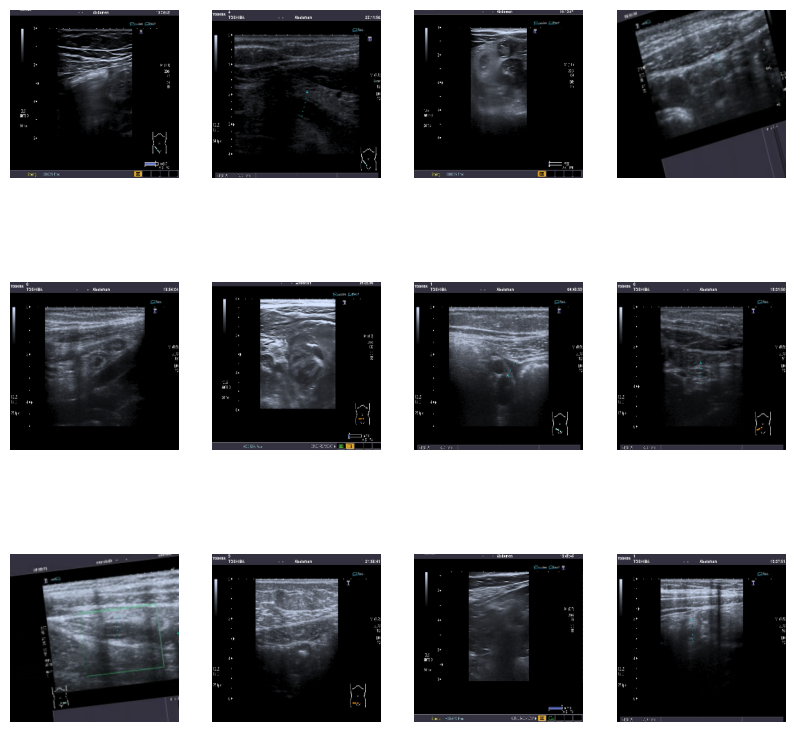

In [7]:
plt.figure(figsize=(10, 10))
for image_batch, labels_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.axis("off")

**Function to Split Dataset**

Dataset should be converted into 3 subsets, namely:

Training: Dataset to be used while training

Validation: Dataset to be tested against while training

Test: Dataset to be tested against after we trained a model

In [8]:
len(dataset)


62

In [9]:
train_size = 0.8
len(dataset)*train_size


49.6

In [10]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1

    ds_size = len(ds)

    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)

    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)

    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)

    return train_ds, val_ds, test_ds

In [11]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [12]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

**Building the Model**


Creating a Layer for Resizing and Normalization

Before we feed our images to network, we should be resizing it to the desired
size. Moreover, to improve model performance, we should normalize the image
pixel value (keeping them in range 0 and 1 by dividing by 256). This should
happen while training as well as inference. Hence we can add that as a layer in our Sequential Model.

In [13]:
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  layers.experimental.preprocessing.Rescaling(1./255),
])


Data Augmentation

Data Augmentation is needed when we have less data, this boosts the accuracy of our model by augmenting the data.

In [14]:
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
])
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

**Applying Data Augmentation to Train Dataset**

In [15]:
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)


**Model Architecture**

We use a CNN coupled with a Softmax activation in the output layer. We also add the initial layers for resizing, normalization and Data Augmentation.

We are going to use convolutional neural network (CNN) here. CNN is popular for image classification tasks.

In [15]:


# Define input shape
input_shape = (IMAGE_SIZE, IMAGE_SIZE, CHANNELS)

# Define data preprocessing layers
resize_and_rescale = tf.keras.Sequential([
    layers.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    layers.Rescaling(1./255)
])

# Build the model
model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),  # Dropout to reduce overfitting
    layers.Dense(2, activation='softmax')
])
model.build(input_shape=(None, IMAGE_SIZE, IMAGE_SIZE, CHANNELS))

# Compile the model
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Display model summary


Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_2 (Sequential)   (None, 256, 256, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 254, 254, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 127, 127, 32)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 62, 62, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 60, 60, 64)       

In [16]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=15,
)

Epoch 1/15
49/49 [==============================] - 222s 534ms/step - loss: 0.6172 - accuracy: 0.6913 - val_loss: 0.5373 - val_accuracy: 0.8132
Epoch 2/15
49/49 [==============================] - 15s 313ms/step - loss: 0.4542 - accuracy: 0.7914 - val_loss: 0.5957 - val_accuracy: 0.8077
Epoch 3/15
49/49 [==============================] - 14s 286ms/step - loss: 0.4249 - accuracy: 0.8132 - val_loss: 0.4157 - val_accuracy: 0.8132
Epoch 4/15
49/49 [==============================] - 14s 280ms/step - loss: 0.4202 - accuracy: 0.8126 - val_loss: 0.4238 - val_accuracy: 0.8132
Epoch 5/15
49/49 [==============================] - 14s 292ms/step - loss: 0.4086 - accuracy: 0.8113 - val_loss: 0.4184 - val_accuracy: 0.8132
Epoch 6/15
49/49 [==============================] - 14s 282ms/step - loss: 0.4103 - accuracy: 0.8145 - val_loss: 0.4671 - val_accuracy: 0.8132
Epoch 7/15
49/49 [==============================] - 14s 276ms/step - loss: 0.4096 - accuracy: 0.8177 - val_loss: 0.4338 - val_accuracy: 0.813

**Run prediction on a sample image**

first image to predict
actual label: appendicitis
1/1 [==============================] - 0s 139ms/step
predicted label: appendicitis


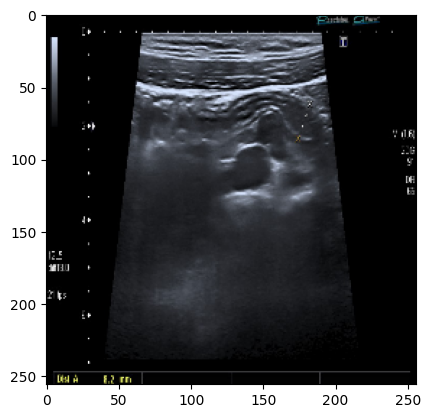

In [17]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):

    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()

    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])

    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

**Write a function for inference**

In [18]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 [==============================] - 0s 18ms/step


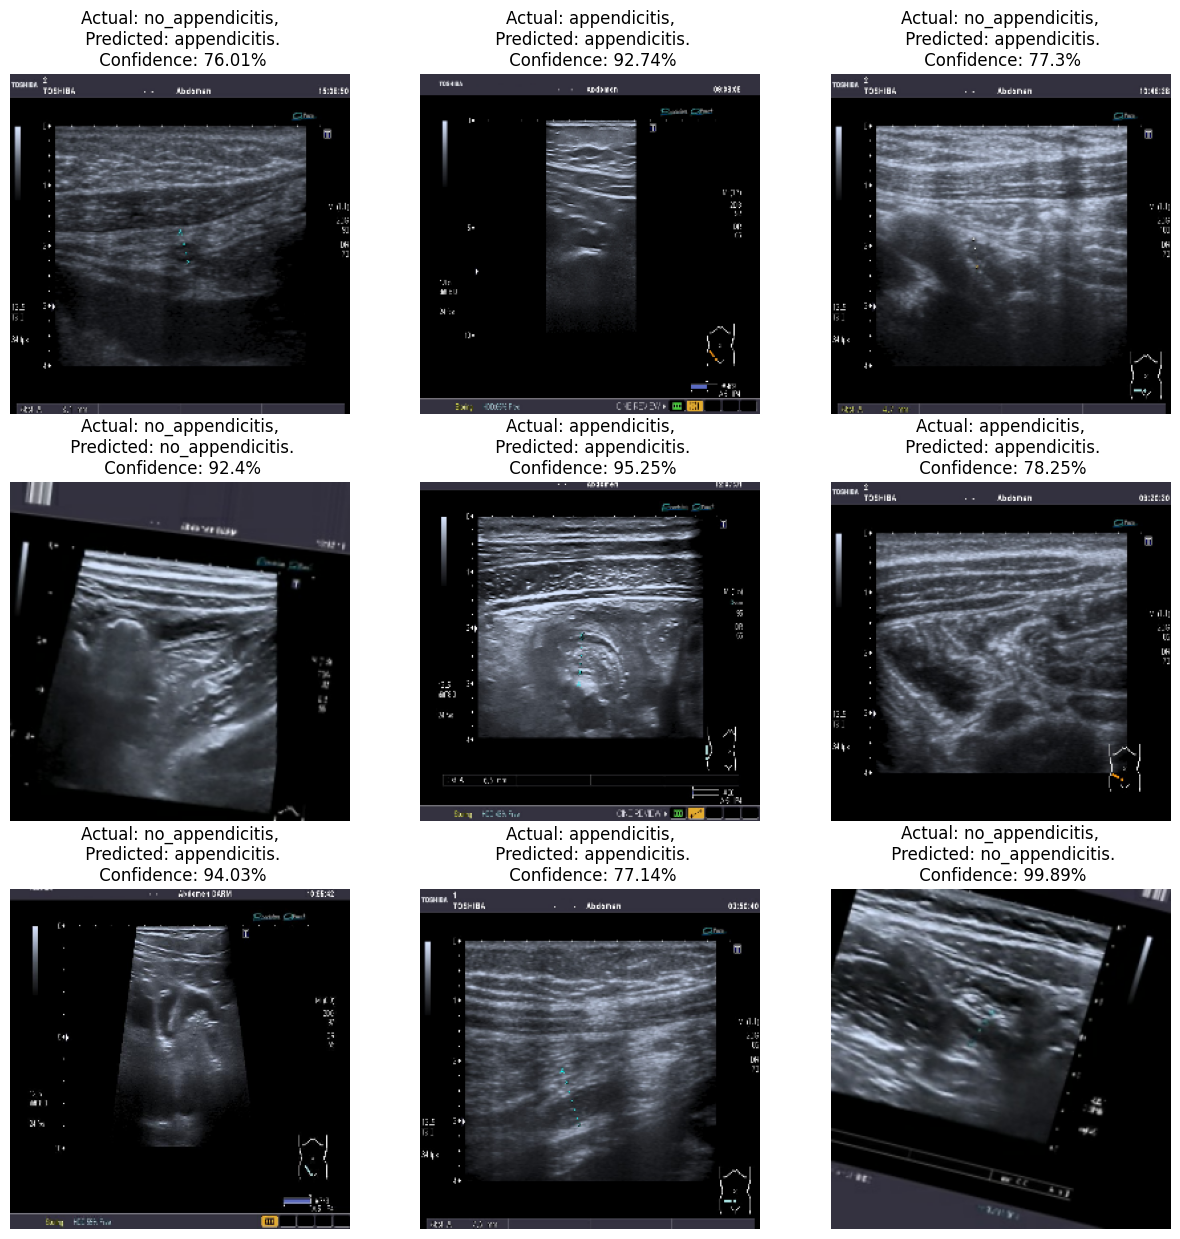

In [19]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))

        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]]

        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")

        plt.axis("off")

**saving our model**

In [20]:
model.save("/content/drive/MyDrive/appendix_prediction/saved_model/appendix_prediction(3).keras")

In [22]:
new_model = tf.keras.models.load_model('/content/drive/MyDrive/appendix_prediction/saved_model/appendix_prediction.keras')

# Show the model architecture
new_model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_2 (Sequential)   (None, 256, 256, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 254, 254, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 127, 127, 32)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 62, 62, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 60, 60, 64)       